# when does alg. X outperform alg. Y?

The goal here is to compare performance between two algorithms (not algorithm classes). 

In [2]:
metric = "Accuracy"
obj_type = "max"

alg_x = "CatBoost"
alg_y = "rtdl_ResNet"

In [3]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np

metadataset_df = pd.read_csv("./results/tuned_fold_results.csv")

In [4]:
# read cleaned metafeatures file
keep_metafeatures_df = pd.read_csv("./results/cleaned_metafeatures.csv", index_col=0)

# drop cols that are all NaN

# keep_metafeatures_df.loc[keep_metafeatures_df.isna().sum() > 0, :]
na_feats = keep_metafeatures_df.isna().sum() == len(keep_metafeatures_df)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
keep_metafeatures_df.drop(columns=na_feat_names, inplace=True)

# replace inf with something else
keep_metafeatures_df.replace([np.inf, -np.inf], 0.0, inplace=True)

all_feature_cols = [c for c in keep_metafeatures_df.columns if c.startswith("f__")]

def simplify(x):
    return x.replace("statistical", "stat").replace("model-based", "model").replace("landmarking", "landmark").replace("skewness", "skew")

nice_feature_names = [simplify(f[len("f__pymfe."):]) for f in all_feature_cols]

dropping cols with only NA: ['f__pymfe.statistical.iq_range', 'f__pymfe.statistical.t_mean']


## merge performance dataset with metafeatures

In [5]:
# get difference in performance between alg x and alg y for each split

df_x = metadataset_df.loc[metadataset_df["alg_name"] == alg_x, :]
df_x.rename(columns={f"normalized_{metric}__test": f"performance_{alg_x}"}, inplace=True)

df_y = metadataset_df.loc[metadataset_df["alg_name"] == alg_y, :]
df_y.rename(columns={f"normalized_{metric}__test": f"performance_{alg_y}"}, inplace=True)

diff_df = df_x.merge(df_y, on="dataset_fold_id", how="inner").merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")

diff_df.loc[:, "performance_diff_x_minus_y"] = diff_df[f"performance_{alg_x}"] - diff_df[f"performance_{alg_y}"]

# drop rows where different is nan
diff_df = diff_df.loc[~diff_df["performance_diff_x_minus_y"].isna(), :]

/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_70443/1911833413.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.rename(columns={f"normalized_{metric}__test": f"performance_{alg_x}"}, inplace=True)
/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_70443/1911833413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.rename(columns={f"normalized_{metric}__test": f"performance_{alg_y}"}, inplace=True)


In [6]:
diff_df.head()

,Unnamed: 0_x,results_bucket_path_x,dataset_fold_id,dataset_name_x,target_type_x,alg_name_x,hparam_source_x,trial_number_x,alg_hparam_id_x,exp_name_x,time__train_x,Log Loss__train_x,AUC__train_x,Accuracy__train_x,F1__train_x,time__val_x,Log Loss__val_x,AUC__val_x,Accuracy__val_x,F1__val_x,time__test_x,Log Loss__test_x,AUC__test_x,Accuracy__test_x,F1__test_x,time__train-eval_x,MSE__train_x,R2__train_x,MSE__val_x,R2__val_x,MSE__test_x,R2__test_x,Accuracy__test_min_x,Accuracy__test_max_x,performance_CatBoost,Accuracy_rank_x,normalized_F1__test_x,F1_rank_x,F1__test_min_x,F1__test_max_x,...,f__pymfe.info-theory.joint_ent.histogram.5,f__pymfe.info-theory.joint_ent.histogram.6,f__pymfe.info-theory.joint_ent.histogram.7,f__pymfe.info-theory.joint_ent.histogram.8,f__pymfe.info-theory.joint_ent.histogram.9,f__pymfe.info-theory.joint_ent.iq_range,f__pymfe.info-theory.joint_ent.kurtosis,f__pymfe.info-theory.joint_ent.max,f__pymfe.info-theory.joint_ent.mean,f__pymfe.info-theory.joint_ent.median,f__pymfe.info-theory.joint_ent.min,f__pymfe.info-theory.joint_ent.quantiles.1,f__pymfe.info-theory.joint_ent.quantiles.3,f__pymfe.info-theory.joint_ent.range,f__pymfe.info-theory.joint_ent.sd,f__pymfe.info-theory.joint_ent.skewness,f__pymfe.info-theory.mut_inf.histogram.0,f__pymfe.info-theory.mut_inf.histogram.1,f__pymfe.info-theory.mut_inf.histogram.2,f__pymfe.info-theory.mut_inf.histogram.3,f__pymfe.info-theory.mut_inf.histogram.4,f__pymfe.info-theory.mut_inf.histogram.5,f__pymfe.info-theory.mut_inf.histogram.6,f__pymfe.info-theory.mut_inf.histogram.7,f__pymfe.info-theory.mut_inf.histogram.8,f__pymfe.info-theory.mut_inf.histogram.9,f__pymfe.info-theory.mut_inf.iq_range,f__pymfe.info-theory.mut_inf.kurtosis,f__pymfe.info-theory.mut_inf.max,f__pymfe.info-theory.mut_inf.mean,f__pymfe.info-theory.mut_inf.median,f__pymfe.info-theory.mut_inf.min,f__pymfe.info-theory.mut_inf.quantiles.1,f__pymfe.info-theory.mut_inf.quantiles.3,f__pymfe.info-theory.mut_inf.range,f__pymfe.info-theory.mut_inf.sd,f__pymfe.info-theory.mut_inf.skewness,f__pymfe.info-theory.ns_ratio,dataset_family,performance_diff_x_minus_y
0,0,results/openml__APSFailure__168868/CatBoost/gp...,openml__APSFailure__168868__fold_0,openml__APSFailure__168868,binary,CatBoost,random_27_s0,27,CatBoost__seed_0__trial_27,gpu-expt-a_091822_065111_fdd9.zip,5.285700,0.012935,0.995266,0.997204,0.997204,0.042606,0.023228,0.990588,0.992632,0.992632,0.040880,0.018710,0.990643,0.994211,0.994211,0.146698,NaN,NaN,NaN,NaN,NaN,NaN,0.981974,0.995395,0.911765,4.0,0.911765,4.0,0.981974,0.995395,...,0.031818,0.0,0.0,0.0,0.142857,0.507416,-1.164597,3.568811,2.380434,2.414503,1.690072,2.070903,2.596461,1.499432,0.5307,0.105515,0.372432,0.04959,0.022059,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.036843,-0.77541,0.215436,0.057252,0.034458,0.002171,0.01528,0.069672,0.197973,0.062782,0.751749,18.249693,openml__APSFailure__168868,-0.019608
1,1,results/openml__APSFailure__168868/CatBoost/gp...,openml__APSFailure__168868__fold_1,openml__APSFailure__168868,binary,CatBoost,random_3_s0,3,CatBoost__seed_0__trial_3,gpu-expt-a_091822_065111_fdd9.zip,3.450149,0.011320,0.995075,0.997632,0.997632,0.038506,0.019020,0.995612,0.994342,0.994342,0.036910,0.024467,0.988862,0.992105,0.992105,0.140466,NaN,NaN,NaN,NaN,NaN,NaN,0.981316,0.992763,0.942529,3.0,0.942529,3.0,0.981316,0.992763,...,0.031818,0.0,0.0,0.0,0.142857,0.507416,-1.164597,3.568811,2.380434,2.414503,1.690072,2.070903,2.596461,1.499432,0.5307,0.105515,0.372432,0.04959,0.022059,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.036843,-0.77541,0.215436,0.057252,0.034458,0.002171,0.01528,0.069672,0.197973,0.062782,0.751749,18.249693,openml__APSFailure__168868,0.206897
2,2,results/openml__APSFailure__168868/CatBoost/gp...,openml__APSFailure__168868__fold_2,openml__APSFailure__168868,binary,CatBoost,random_8_s0,8,CatBoost__seed_0__trial_8,gpu-expt-a_091822_065111_fdd9.zip,11.938921,0.007183,0.998218,0.998964,0.998964,0.030509,0.019060,0.988658,0.995132,0.995132,0.037456,0.018976,0.995551,0.993421,0.993421,0.

# when does Alg. X outperform Alg Y?

In [7]:
y = (diff_df["performance_diff_x_minus_y"] > 0).astype(int)
x = diff_df[all_feature_cols].values.clip(-1e10, 1e10)

### correlation of metafeatures with performance difference

In [8]:
import scipy 
corrs = []
p_values = []
for f in all_feature_cols:
    c = scipy.stats.pearsonr(diff_df[f].values, diff_df["performance_diff_x_minus_y"].values)
    corrs.append(c.statistic)
    p_values.append(c.pvalue)

print("highest-correlated features with ACTUAL diff:")
abs_coef = np.abs(corrs)

idx_sorted = (-abs_coef).argsort()

num_print_feats = 30

for i in range(num_print_feats):
    print(f"{nice_feature_names[idx_sorted[i]]}: {corrs[idx_sorted[i]]} (p={p_values[idx_sorted[i]]})")


highest-correlated features with ACTUAL diff:
stat.skew.sd: 0.30817715410750735 (p=6.1487963675185754e-37)
stat.skew.mean: 0.29312458328175783 (p=2.0056396617414928e-33)
stat.kurtosis.mean: 0.2730918436260825 (p=4.573099756478043e-29)
stat.max.histogram.0: 0.26382072934652745 (p=3.6093246715585265e-27)
stat.range.histogram.0: 0.25229225469574046 (p=6.507966839139555e-25)
stat.sd.histogram.0: 0.23262140326111636 (p=2.538956355385862e-21)
stat.h_mean.max: 0.22663263176798523 (p=2.7201624877161614e-20)
stat.iq_range.iq_range: 0.22552489498105827 (p=4.186992927362849e-20)
stat.cov.iq_range: 0.22550524050992413 (p=4.2190689029806757e-20)
stat.mad.histogram.0: 0.22490976131929674 (p=5.314783471397524e-20)
stat.mean.iq_range: 0.2241627679090571 (p=7.093506215612344e-20)
stat.t_mean.quantiles.3: 0.22372929173394646 (p=8.383175526807198e-20)
stat.sd.iq_range: 0.21971768743124817 (p=3.8690434164150902e-19)
stat.t_mean.iq_range: 0.21959731298074103 (p=4.04886710023192e-19)
stat.gravity: 0.2190732

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


### small plots just for context

<AxesSubplot: >

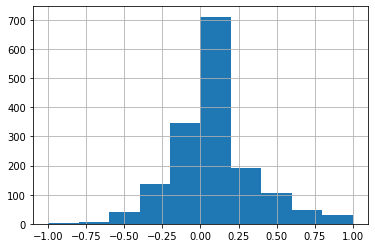

In [9]:
diff_df["performance_diff_x_minus_y"].hist()

<AxesSubplot: >

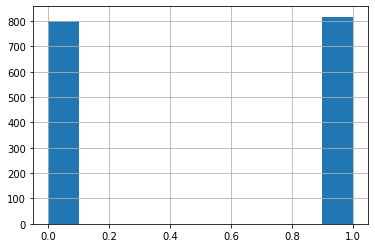

In [10]:
y.hist()

### fit a small decision tree

In [11]:
from sklearn import tree, metrics

clf = tree.DecisionTreeClassifier(max_depth=3).fit(x, y)
print(f"classes: {clf.classes_}")

classes: [0 1]


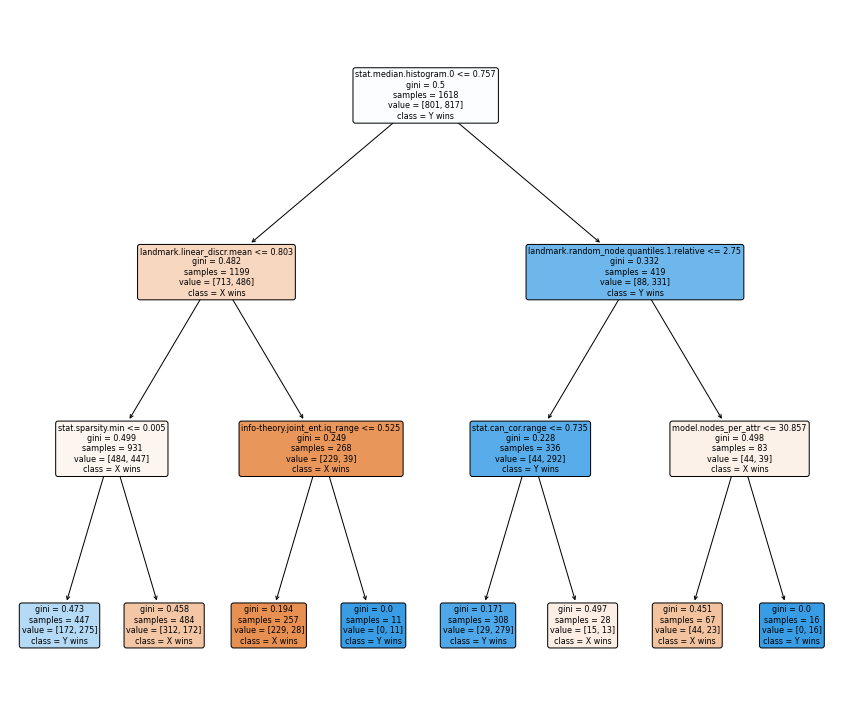

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 13))

annotations = tree.plot_tree(
    clf, 
    feature_names=nice_feature_names, 
    class_names=["X wins", "Y wins"], 
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

### train a decision tree model using leave-one-dataset-out train/test split

Use the same `x` and `y` defined above.

In [17]:
from xgboost import XGBClassifier

# get dataset names
dataset_basename = diff_df["dataset_name"].apply(lambda x: "__".join(x.split("__")[1:3]))
all_datasets = dataset_basename.unique()

num_feats_list = list(range(1, 10, 2))
depth_feats = []
depth_acc = []
for i, depth in enumerate(num_feats_list):

    depth_acc_list = []
    depth_feat_imp_list = []
    for dataset in all_datasets:
            
        # create train-test splits based on dataset 
        test_ind = dataset_basename == dataset
        train_ind = ~test_ind

        x_train = x[train_ind, :]
        x_test = x[test_ind, :]

        y_train = y[train_ind]
        y_test = y[test_ind]

        # fit a tree with limited max depth
        # clf = tree.DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)
        clf = tree.DecisionTreeClassifier(max_depth=depth, min_samples_leaf=5).fit(x_train, y_train)

        depth_acc_list.append(metrics.accuracy_score(y_test, clf.predict(x_test)))

        depth_feat_imp_list.append(clf.feature_importances_)

    depth_feats.append(depth_feat_imp_list)
    depth_acc.append(depth_acc_list)
    print(f"depth={depth} | avg (std) MAE = {np.mean(depth_acc[i]):.5f} {np.std(depth_acc[i]):.5f} | num-feats = {np.sum(np.sum(depth_feats[i], axis=0) > 0)}")


depth=1 | avg (std) MAE = 0.62791 0.32620 | num-feats = 2


KeyboardInterrupt: 